In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

replicating local resources


In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [3]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2020-02-29 10:07:43--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9,5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9,48M  2,02MB/s    in 5,1s    

2020-02-29 10:07:49 (1,87 MB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

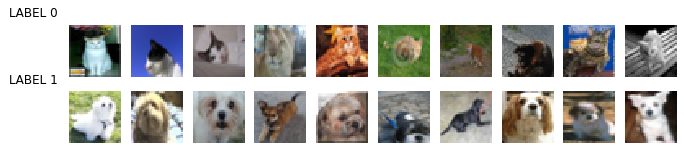

In [4]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    403
1    397
dtype: int64

distribution of test classes
1    100
0    100
dtype: int64


## Part 1: train a model with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**training params**:
- 10 epochs and batch_size=32
- use `validation_set` to monitor performance on test data

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [ ]:
def get_model():
    ...
    
model1 = get_model()
model1.fit(...)

In [21]:
def get_model():
    num_classes = 2
    img_size = 32
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = xtf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model1 = get_model()
model1.summary()
model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_3 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3904      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160

In [47]:
s=b"""
def get_model():
    num_classes = 2
    img_size = 32
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model1 = get_model()
model1.summary()
model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))
"""


In [48]:
binascii.hexlify(s)

b'0a646566206765745f6d6f64656c28293a0a202020206e756d5f636c6173736573203d20320a20202020696d675f73697a65203d2033320a20202020696e70757473203d2074662e6b657261732e496e7075742873686170653d28696d675f73697a652c696d675f73697a652c33292c206e616d653d22696e7075745f3122290a202020206c6179657273203d2074662e6b657261732e6c61796572732e436f6e7632442839362c2831312c3131292c2061637469766174696f6e3d2272656c75222928696e70757473290a202020206c6179657273203d2074662e6b657261732e6c61796572732e4d6178506f6f6c32442828322c322929286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e436f6e7632442836302c2831312c3131292c2061637469766174696f6e3d2272656c752229286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e466c617474656e2829286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e44656e73652836342c2061637469766174696f6e3d74662e6e6e2e72656c7529286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e44656e73652836342c2061637469766174696f6e

In [50]:
# uncomment for solution
#k = b'0a646566206765745f6d6f64656c28293a0a202020206e756d5f636c6173736573203d20320a20202020696d675f73697a65203d2033320a20202020696e70757473203d2074662e6b657261732e496e7075742873686170653d28696d675f73697a652c696d675f73697a652c33292c206e616d653d22696e7075745f3122290a202020206c6179657273203d2074662e6b657261732e6c61796572732e436f6e7632442839362c2831312c3131292c2061637469766174696f6e3d2272656c75222928696e70757473290a202020206c6179657273203d2074662e6b657261732e6c61796572732e4d6178506f6f6c32442828322c322929286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e436f6e7632442836302c2831312c3131292c2061637469766174696f6e3d2272656c752229286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e466c617474656e2829286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e44656e73652836342c2061637469766174696f6e3d74662e6e6e2e72656c7529286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e44656e73652836342c2061637469766174696f6e3d74662e6e6e2e72656c7529286c6179657273290a202020206c6179657273203d2074662e6b657261732e6c61796572732e44726f706f757428302e3229286c6179657273290a2020202070726564696374696f6e73203d2074662e6b657261732e6c61796572732e44656e7365286e756d5f636c61737365732c2061637469766174696f6e3d74662e6e6e2e736f66746d61782c206e616d653d226f75747075745f312229286c6179657273290a202020206d6f64656c203d2074662e6b657261732e4d6f64656c28696e70757473203d20696e707574732c206f7574707574733d70726564696374696f6e73290a202020200a202020206d6f64656c2e636f6d70696c65286f7074696d697a65723d276164616d272c0a2020202020202020202020202020202020206c6f73733d277370617273655f63617465676f726963616c5f63726f7373656e74726f7079272c0a2020202020202020202020202020202020206d6574726963733d5b276163637572616379275d290a202020200a2020202072657475726e206d6f64656c0a0a6d6f64656c31203d206765745f6d6f64656c28290a6d6f64656c312e73756d6d61727928290a6d6f64656c312e66697428785f747261696e2c20795f747261696e2c2065706f6368733d31302c2062617463685f73697a653d33322c2076616c69646174696f6e5f646174613d28785f746573742c20795f7465737429290a'
#import binascii; print (binascii.a2b_hex(k).decode())


observe the obtained weights

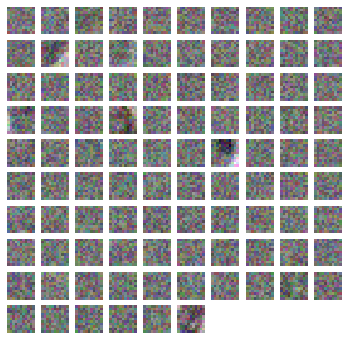

In [22]:
mlutils.display_imgs(model1.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [23]:
!unzip -u alexnet_finetuned_minicifar.model.zip

Archive:  alexnet_finetuned_minicifar.model.zip


In [24]:
from tensorflow.keras.models import load_model

model1 = get_model()
model2 = load_model("alexnet_finetuned_minicifar.model")
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                976 

### 1. Print shapes of weights from both models

you should get something like this:

     -- model 1 weights --
    (11, 11, 3, 96)
    (96,)
    (11, 11, 96, 60)
    (60,)
    (60, 64)
    (64,)
    (64, 64)
    (64,)
    (64, 2)
    (2,)
     -- model 2 weights --
    (11, 11, 3, 96)
    (96,)
    (11, 11, 96, 60)
    (60,)
    (60, 16)
    (16,)
    (16, 3)
    (3,)


In [ ]:
w1 = ... # weights from model 1
w2 = ... # weights form model 2
# ... print shapes ...


In [46]:
# uncomment for solution
#k = b'0a7731203d206d6f64656c312e6765745f7765696768747328290a7732203d206d6f64656c322e6765745f7765696768747328290a0a7072696e74202822202d2d206d6f64656c20312077656967687473202d2d22290a666f72206920696e2077313a0a202020207072696e742028692e7368617065290a202020200a7072696e74202822202d2d206d6f64656c20322077656967687473202d2d22290a666f72206920696e2077323a0a202020207072696e742028692e7368617065290a'
#import binascii; print (binascii.a2b_hex(k).decode())

### 2. transfer weights!!. you should transfer weights and biases of only the convolutional layers

1. copy the appropriate weights values from `w2` to `w1` (this is `numpy`)
2. set the weights on `model1`

In [ ]:
...

In [45]:
# uncomment for solution
#k = b'0a666f72206920696e2072616e67652834293a0a20202020617373657274206e702e616c6c636c6f73652877325b695d2e73686170652c2077315b695d2e7368617065292c20227765696768747320737472756374757265206e6f7420657175616c20222b7374722877315b695d2e7368617065292b222c20222b7374722877325b695d2e7368617065290a202020207072696e74202822636f7079696e672077656967687473222c20692c20222d2d3e222c2077315b695d2e7368617065290a2020202077315b695d203d2077325b695d2e636f707928290a202020200a6d6f64656c312e7365745f77656967687473287731290a'
#import binascii; print (binascii.a2b_hex(k).decode())

### train!!!

In [ ]:
...

In [43]:
# uncomment for solution
#k = b'0a6d6f64656c312e66697428785f747261696e2c20795f747261696e2c2065706f6368733d31302c2062617463685f73697a653d33322c2076616c69646174696f6e5f646174613d28785f746573742c20795f7465737429290a'
#import binascii; print (binascii.a2b_hex(k).decode())


model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))



### check you have trained with transferred weights

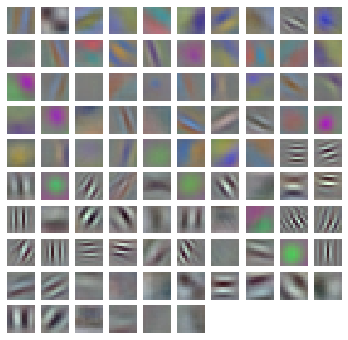

In [39]:
mlutils.display_imgs(model1.get_weights()[0])